### KUCHAŘKA na druhej testík ML
nemáte zač

ReLu, dělám ReLu
jsem tý neuronce nejspíš k smíchu


In [66]:
# IMPORTÍKY

import numpy as np
np.random.seed(42) # případně změnit seed
import matplotlib.pyplot as plt
import time 

# PyTorch imports 
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torch.autograd import Variable

## DATA - simulace
pokud nám nedá data, tak je simulujeme

In [67]:
from simulate_images import generate_image_shapes

# testuju, jaký data dostanu a pak na ně aplikuju class SimDataset
height, width, count = 28, 28, 9    # count je počet pásem (bands)
noise = 0.2
X, Y, y_label = generate_image_shapes(height, width, count, noise)

In [68]:
# data exploration
print(f"X shape: {X.shape}")
print(f"Unikátní hodnoty v y_label: {np.unique(y_label)}")   # kolik máme klasifikačních tříd

object_shapes = ['square', 'triangle', 'circle']  
for label in y_label: 
    print(f'label {label} = {object_shapes[label]}')

X shape: (9, 1, 28, 28)
Unikátní hodnoty v y_label: [0 1 2]
label 2 = circle
label 0 = square
label 2 = circle
label 2 = circle
label 0 = square
label 0 = square
label 2 = circle
label 1 = triangle
label 2 = circle


Label: 2


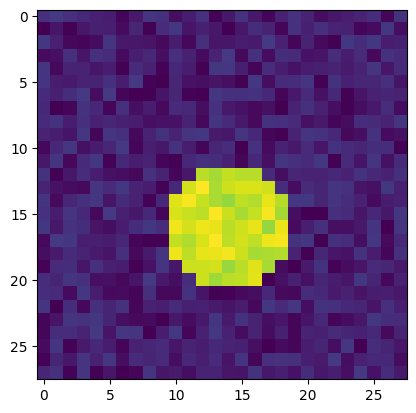

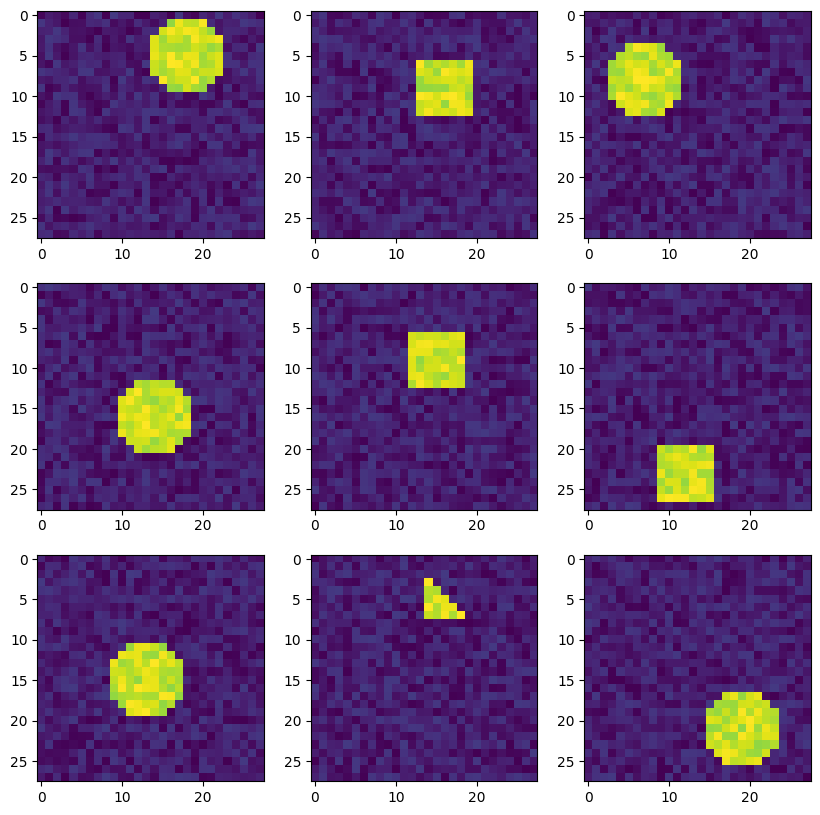

In [69]:
# KOUKÁME NA DATA
# printneme si třetí obrázek
image_no=3
print(f'Label: {y_label[image_no]}')
plt.imshow(X[image_no][0,:,:])

# a tady mrkneme na všechny
plt.figure(figsize=(10,10)) 
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X[i][0,:,:])

**class SimDataset** aka ctrl+c a ctrl+v prostě
- znovu vytváří data pomocí `generate_image_shapes` a dědí z `Dataset`, takže už má parametry toho
- volám ji pak v `get_data_loaders` a pomocí toho vytvořím testovací a trénovací data
- musím to udělat? protože chci dělat deep learning, takže na data musím aplikovat `DataLoader` (je to class z torch knihovny) <-- prostě musím a basta

In [70]:
# Helper class to generate simulated images, masks and labels and getting an image when called  
class SimDataset(Dataset):
    def __init__(self, height, width, count, noise):
        self.input_images, self.target_masks, self.target_labels = generate_image_shapes(height, width, count, noise)

    def __len__(self):
        return len(self.input_images)

    # indexing operation on objects; enable instances of the class 
    # to use the indexing syntax to retrieve elements
    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        label= self.target_labels[idx] 

        return [image, mask, label]

In [71]:
# DEFINUJEME ROZDĚLENÍ DAT NA TRÉNOVACÍ A TESTOVACÍ 
def get_data_loaders(height, width, noise, train_size, test_size, batch_size=5):

    # simulated based on given parameters
    train_set = SimDataset(height, width, train_size, noise) 
    test_set = SimDataset(height, width, test_size, noise) 

    # z jednotlivých obrázků DataLoader udělá jakoby balíček
    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)

    return train_dataloader, test_dataloader

In [72]:
# DĚLÍME DATA NA TRÉNOVACÍ A TESTOVACÍ
batch_size = 20 # kolik chci celkem obrázků
height, width = 28, 28  # image size - ovlivňuje sekvenci konvoluce
noise = 0.5 

# 500 - ale může být cokoliv jiného, Brodský prý preferuje 50 a 50
train_dataloader, test_dataloader = get_data_loaders(height, width, noise, train_size = 500, test_size = 500, 
                                                     batch_size = batch_size)

In [73]:
# nakonec uložíme data z train_dataloader do proměnných, aby to neuronka schroupala
X, Y, y_label = next(iter(train_dataloader))
print(f"Trochu data exploration; X.shape je {X.shape}")

Trochu data exploration; X.shape je torch.Size([20, 1, 28, 28])


## MODEL - definování
budeme dělat:
- convoluci, pak ReLu a MaxPooling
- potom uděláme flatten
- a nakonec spojíme
a to je děti jeden layer

Shape outputu 1: torch.Size([20, 9, 28, 28])


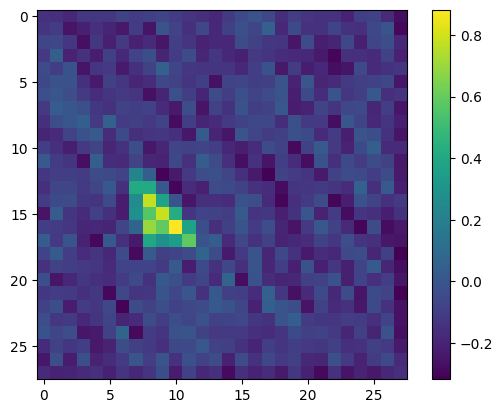

In [91]:
# KONVOLUCE = definuju parametry pro moji konvoluci

# stride = krok posunu okna o daný počet pixelů (jakoby kolik přeskočím) v obou směrech
# padding = pro zachování původního rozměru inputu; když padding = 0, tak tam NENÍ!!!
conv = nn.Conv2d(in_channels = 1, out_channels = 9, kernel_size = 3, stride = 1, padding =1) 

# zkoušíme to použít, jestli to funguje (optional)
output1 = conv(X)
print(f"Shape outputu 1: {output1.shape}") 

# LET'S PLOT IT
# první číslo = počet obrázků v datasetu
# druhý číslo = počet bandů jednoho obrázku
# ty dvě další je počet pixelů
plt.imshow(output1[19, 8, :, :].detach())    # u čísel nemůžu jít výš než na n-1 oproti mého počtu obrázků/bands
plt.colorbar()

Shape outputu po ReLu: torch.Size([20, 9, 28, 28])


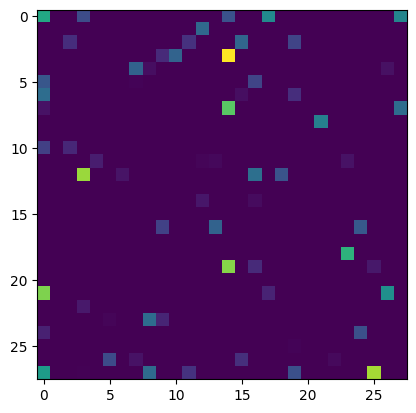

In [92]:
# RELU (activation layer aktivuje části, které si myslí, že jsou important) 
relu = nn.ReLU()    # definice

# zkoušíme to tady udělat, jestli funguje, ale je to optional
output2 = relu(output1)
print(f"Shape outputu po ReLu: {output2.shape}")    # neměl by se shape změnit oproti conv

# koukáme, co nám ReLu rozsvítila
plt.imshow(output2[0, 2, :, :].detach())

Shape po max pooling: torch.Size([20, 9, 14, 14])


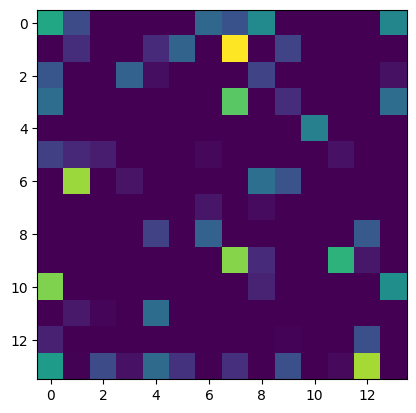

In [93]:
# MAX POOLING
pool = nn.MaxPool2d(kernel_size=2)  # definice

# zas to jen zkoušíme (optional)
output3 = pool(output2)
print(f"Shape po max pooling: {output3.shape}")

# vočíhneme vobrázek
plt.imshow(output3[0, 2, :, :].detach())

In [108]:
# KONTROLY SHAPU 
# s relu neztrácíme dimenzi (output1 a output2 jsou stejné), ale s max pooling jo

print(f"Po konvoluci: {output1.shape}")
print(f"Po ReLu: {output2.shape} \n")
print("Sedí ti ReLu a konvoluce??")
print(f"Po max pooling: {output3.shape}")   # max pooling

Po konvoluci: torch.Size([20, 9, 28, 28])
Po ReLu: torch.Size([20, 9, 28, 28]) 

Sedí ti ReLu a konvoluce??
Po max pooling: torch.Size([20, 9, 14, 14])


mám jen jednu convoluci, takže už jdeme dělat flatten

In [109]:
# FLATTEN - tohle není definice, ale čekuju, že funguje
flattened_output = output3.view(output3.size(0), -1)    # pustíš na výsledek max pooling
print(f"Shape po flatten: {flattened_output.shape}") 

# měl by vyjít tensor: [počet obrázků, zbytek parametrů]    zbytek parametrů = počet pásem * resolution * resolution

Shape po flatten: torch.Size([20, 1764])


**LINEÁRNÍ TRANSFORMACE**

`linear = nn.Linear` (resolution po max pooling * resolution po max pooling * počet pásem, počet tříd ke klasifikaci)

In [110]:
# LINEÁRNÍ TRANSFORMACE 

# buď tam dám výsledek max poolingu [20,9,14,14]; druhé číslo je počet klasifikovaných tříd na výstupu
linear = nn.Linear(14*14*9, 3)

# nebo tak můžeš rovnou napsat číslo rovnou z flattening
# linear = nn.Linear(1764, 3)

out_fc = linear(flattened_output)  
print(f"Jeden velkej dlouhej vošklivej tensor: {out_fc}")   # ty pásma se seřadí za sebou

Jeden velkej dlouhej vošklivej tensor: tensor([[ 0.0100,  0.0972,  0.1244],
        [ 0.0468,  0.0711,  0.1481],
        [-0.0558,  0.0433,  0.0524],
        [ 0.0017,  0.0272,  0.0953],
        [ 0.0362,  0.0658,  0.0996],
        [-0.0122,  0.0321,  0.0420],
        [-0.0443, -0.0377,  0.0133],
        [-0.0158, -0.0320,  0.0544],
        [-0.1174, -0.0463,  0.0176],
        [-0.0152,  0.0752,  0.0252],
        [ 0.0638,  0.0037, -0.0051],
        [-0.0681, -0.0286,  0.1043],
        [ 0.0534,  0.1485,  0.1294],
        [-0.0048,  0.0620,  0.1233],
        [-0.0773, -0.0293,  0.0608],
        [ 0.0189,  0.0228,  0.0439],
        [-0.0126,  0.0312,  0.0621],
        [-0.0276,  0.0070,  0.1010],
        [ 0.0427,  0.0812,  0.0056],
        [ 0.0200,  0.0378,  0.0475]], grad_fn=<AddmmBackward0>)


takže tohle celý bylo pro srandu králíkům a teď the real stuff (ale jakoby tu srandu nejde přeskočit, protože musíš dělat to data exploration)

## CNN (short version but not really)
nic tady nekontroluju, je to dost o modlení a o štěstí

In [111]:
# přeuložíme si data do jiné proměnné
x =X[:, :, :, :]
print(f"x shape: {x.shape}")

x shape: torch.Size([20, 1, 28, 28])


In [121]:
# TADY TESTUJEME ZNOVU, abychom byli 100% sure, že to funguje

# definitions (inicializace)
conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)     # výstup první konvoluce musí sedět jako vstup do té druhé
relu1 = nn.ReLU()
npool1 = nn.MaxPool2d(kernel_size=2)

# another definitions
conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1) 
relu2 = nn.ReLU()
npool2 = nn.MaxPool2d(kernel_size=2)

# předefinujeme si i lineární transformaci
linear1 = nn.Linear(128*7*7, 3)     # hodnoty sem dostaneš až z out_flat [output out_flat, počet klasifikačních pásem]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [124]:
# DALŠÍ INICIALIZACE kde aplikuju tu předtím

# forward
out = conv1(x)
out = relu1(out)
out = npool1(out)

# forward again
out = conv2(out)
out = relu2(out)
out = npool2(out)

# flattened output
out_flat = out.view(out.size(0), -1)
print(f"out: {out.shape}") 
print(f"out_flat: {out_flat.shape} <-- friendly reminder: hoď mě do lineární transformace")  

# classification output
out_cls = linear1(out_flat)
print(f"out_cls: {out_cls.shape}") # vyjde mi [počet obrázků, počet klasifikačních tříd]

out: torch.Size([20, 128, 7, 7])
out_flat: torch.Size([20, 6272]) <-- friendly reminder: hoď mě do lineární transformace
out_cls: torch.Size([20, 3])


funguje ti to? good job, teď na to teprve pustíš ten CNN

In [125]:
# CNN Model - inicializujeme ho

class CNNModel(nn.Module):
    def __init__(self, num_channels):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1, padding = 1) 
        self.relu1 = nn.ReLU()
        self.npool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1) 
        self.relu2 = nn.ReLU()
        self.npool2 = nn.MaxPool2d(kernel_size=2)

        self.linear1 = nn.Linear(128*7*7, 3)   


    def forward(self, x):   
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.npool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.npool2(out)
        out_flat = out.view(out.size(0), -1)
        out_cls = self.linear1(out_flat)

        return out_cls


In [115]:
# TESTOVÁNÍ MODELU
model = CNNModel(num_channels=1)    # num channels je, že mám jedno pásmo

#model   # printne ty parametry

In [116]:
# INICIALIZACE loss function
criteria = nn.CrossEntropyLoss() 

In [117]:
# nastav learning rate
learning_rate = 0.01

# inicializiace optimizeru 
omptimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

hurá, jdeme TRÉNOVAT MODEL

(prostě Ctrl+C a Ctrl+V bestie, don't overthink it)

In [118]:
# Step 7: Train Model
start = time.time()

# training setup 
num_epochs = 100  # na začátku dej 1 - abychom otestovali, jestli loop funguje

# log loss history - uložíme to do slovníků
train_loss, test_loss = [], []

# loop over the epoches 
for epoch in range(num_epochs):
    
    for phase in ['train', 'test']: # poběží tu dva procesy, které se prostřídají
        if phase == 'train':
            model.train(True)  # Set training mode = true
            dataloader = train_dataloader
        else:
            model.train(False)  # Set model to evaluate mode
            dataloader = test_dataloader

        step = 0

        # iterate over batches of data
        for X, Y, y_label in dataloader:    # dataloader vrací: image, mask and labels for the image
            step += 1

            # make the input X and y Pytorch Variable() (with gradient)
            x = Variable(X)
            y_l = Variable(y_label)
         
            # TRAINING PHASE
            # run forward pass
            if phase == 'train':
                # zero the gradients
                omptimizer.zero_grad()

                # calcualte model outputs based on input X 
                outputs = model(x)

                # calcualte loss based on your criterion 
                loss = criteria(outputs, torch.tensor(y_l, dtype = torch.long))

                # the backward pass frees the graph memory, so there is no need for torch.no_grad in this training pass back propagation 
                loss.backward()

                # optimizer step 
                omptimizer.step()
            

            # TESTING PHASE
            else:
                with torch.no_grad():
                    # calculate model outputs based on input X 
                    output = model(x)

                    # calculate loss (beavaere it takes Long (integer) for cathegorical values)
                    loss = criteria(output, torch.tensor(y_l, dtype = torch.long)) 
            
            # save losses and print them 
            if phase=='train': 
                train_loss.append(loss)
                #print('Epoch: {}  Train Loss: {} '.format(epoch, loss)) 
            else: 
                # append test loss
                test_loss.append(loss)
                #print('Epoch: {}  Test Loss: {} '.format(epoch, loss)) 

                # report epoch
    print('Epoch: {}  Train Loss: {} - Test Loss {} '.format(epoch, train_loss[-1], test_loss[-1]))
                                        

print('Computation completed! ')
print('---')
time_elapsed = time.time() - start
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))        

C:\Users\vandu\AppData\Local\Temp\ipykernel_18552\886836947.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criteria(outputs, torch.tensor(y_l, dtype = torch.long))
C:\Users\vandu\AppData\Local\Temp\ipykernel_18552\886836947.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criteria(output, torch.tensor(y_l, dtype = torch.long))


Epoch: 0  Train Loss: 1.062095284461975 - Test Loss 1.0973851680755615 
Epoch: 1  Train Loss: 1.1732155084609985 - Test Loss 1.0851346254348755 
Epoch: 2  Train Loss: 1.049070119857788 - Test Loss 1.05483078956604 
Epoch: 3  Train Loss: 1.008819341659546 - Test Loss 1.0603301525115967 
Epoch: 4  Train Loss: 0.9709411859512329 - Test Loss 0.9621856808662415 
Epoch: 5  Train Loss: 0.9987096786499023 - Test Loss 1.005131721496582 
Epoch: 6  Train Loss: 0.8362229466438293 - Test Loss 1.015039086341858 
Epoch: 7  Train Loss: 0.7697346210479736 - Test Loss 0.8323685526847839 
Epoch: 8  Train Loss: 0.6364291310310364 - Test Loss 0.6821306943893433 
Epoch: 9  Train Loss: 0.6237381100654602 - Test Loss 0.738804042339325 
Epoch: 10  Train Loss: 0.6413553357124329 - Test Loss 0.7135233283042908 
Epoch: 11  Train Loss: 0.4130346179008484 - Test Loss 0.5044090747833252 
Epoch: 12  Train Loss: 0.46370846033096313 - Test Loss 0.5170319676399231 
Epoch: 13  Train Loss: 0.4897349774837494 - Test Loss 0

In [119]:
# train_loss i test_loss je tenzor, takže to musíme detachnout, aby to šlo vyplotovat
train_loss_d = [d.detach() for d in train_loss]
test_loss_d = [d.detach() for d in test_loss]

Text(0, 0.5, 'loss')

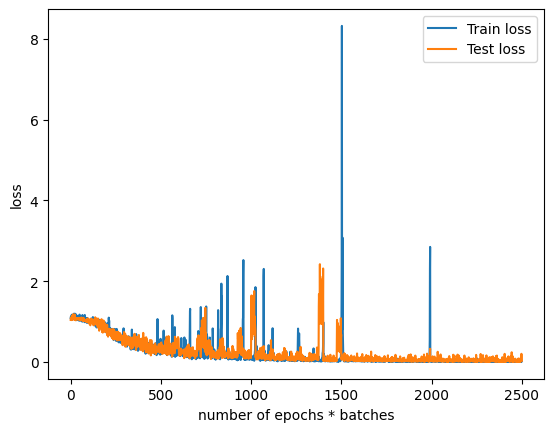

In [120]:
plt.plot(train_loss_d, label = "Train loss")
plt.plot(test_loss_d, label = "Test loss")
plt.legend()
plt.xlabel("number of epochs * batches")
plt.ylabel("loss")

interpretace grafíku?
- **peaks** = vzorek mám rozdělený do batches a občas to rozdělení není úplně ideální a to způsobuje ty peaks, protože model ty data ještě neviděl, tak šmudla panikaří
- **výsledná loss** je v poslední epoše a chceš aby byla co možná nejmenší